# Corelations of features per adjacent counties
County data pipeline adopted from Michael's code

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobility = load_od_baseline()

hospitals = load_acute_care(beds=True)

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

# County adjacency edge list
with open('../data/processed/county_adjacency_edge_dict.pkl', 'rb') as f:
    county_adj = pickle.load(f)

/Users/darius/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Mobility Last Updated 05-08
Deaths Last Updated 05-26


In [161]:
N_DAYS = 9
ONSET_THRESH = 3
GROWTH_THRESH = 0

In [162]:
# Get death dataframe date columns
death_dates = get_date_columns(deaths, return_dtimes=False)

In [163]:
def get_onset_date(row, thresh):
    above = row[row >= thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

In [164]:
death_data = pd.DataFrame(columns=['FIPS', 'Deaths'])
deaths_df = deaths[['FIPS']+death_dates]

# Get all existing data n_days from the death_thresh death.
for i in range(len(deaths_df)):
    county = deaths_df.iloc[i]

    # Iterate through dates to find first date with deaths >= death thresh
    for j in range(len(death_dates)):
        if county[death_dates[j]] >= ONSET_THRESH:

            # See if this happened n_days or more before current day
            try:
                n_days_later = death_dates[j+N_DAYS]

                # Make sure the data is bug-free
                bad_data=False
                for k in range(n_days):
                    if county[n_days_later] < county[dates[j+k]]:
                        bad_data=True
                if not bad_data:
                    death_data = death_data.append({'FIPS': county['FIPS'], 'Deaths':county[n_days_later]}, ignore_index=True)
                break

            except:
                break

In [166]:
## Normalize deaths by pop total
deaths_df = deaths[['FIPS']+death_dates]
deaths_df.dropna(subset=['FIPS'], inplace=True)
deaths_df = deaths_df.astype({'FIPS':int})

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row, thresh=ONSET_THRESH), axis=1)

## Drop counties with no onset
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

## Only counties with N_DAYS worth of data after onset
deaths_df = deaths_df[deaths_df['onset'].apply(
    lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= N_DAYS
)]

## Remove counties with significant growth decrease
deaths_df = deaths_df[
    deaths_df.apply(
        lambda r: r[[d for d in death_dates if 
            str2date(d) >= str2date(r['onset']) and 
            str2date(d) <= lag_date(str2date(r['onset']
        ), 
        lag=N_DAYS, backwards=False)]].diff().min() >= GROWTH_THRESH, axis=1
    )
]

## Get the cumulative deaths over the period
deaths_df['cum_deaths'] = deaths_df.apply(
    lambda r: sum(r[[d for d in death_dates if 
        str2date(d) >= str2date(r['onset']) and 
        str2date(d) <= lag_date(str2date(r['onset']
    ), 
    lag=N_DAYS, backwards=False)]]), axis=1)

## Get the number of deaths at N_DAYS from onset
deaths_df['n_days_out'] = deaths_df.apply(
    lambda r: r[lag_date(str2date(r['onset']), lag=N_DAYS, backwards=False, return_date=False)], axis=1
)

/Users/darius/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [167]:
deaths_df['n_days_out'].max()

345

In [168]:
cum_deaths = deaths_df[['FIPS', 'cum_deaths', 'n_days_out']]
cum_deaths = pd.merge(cum_deaths, hospitals, on='FIPS')

m50_dates = get_date_columns(m50, return_dtimes=False)
m50['baseline'] = m50.apply(lambda x: x[m50_dates[:7]].mean(), axis=1)
cum_deaths = pd.merge(cum_deaths, m50[['FIPS', 'baseline']], on='FIPS')
cum_deaths.rename(columns={'baseline':'m50'}, inplace=True)
cum_deaths = pd.merge(cum_deaths, od_mobility, on='FIPS')

# confounder_dict = {
#     'POP_ESTIMATE_2018' : -1,
#     'Density per square mile of land area - Population': 0,
#     'Rural-urban_Continuum Code_2013': 0,
#     'Total_age65plus': 0,
# }
# cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + list(confounder_dict.keys())], on='FIPS')
# cum_deaths['normalized_deaths'] = cum_deaths.apply(
#     lambda row: normalize(row, confounder_dict), axis=1
#     )
# for col in ['inter_movement', 'in_movement', 'out_movement']:
#     cum_deaths[col] = cum_deaths.apply(lambda row: row[col] / row['POP_ESTIMATE_2018'], axis=1)
# cum_deaths.dropna(axis=0, inplace=True)

In [169]:
static_features = counties[['FIPS', 'Rural-urban_Continuum Code_2013', 'Density per square mile of land area - Population', 'Percent of adults with less than a high school diploma 2014-18', 'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus', 'POP_ESTIMATE_2018']]
static_features = static_features.dropna()

In [170]:
cum_deaths = cum_deaths.merge(static_features, on="FIPS")

In [171]:
cum_deaths.head()

,FIPS,cum_deaths,n_days_out,Beds,HospCt,m50,inter_movement,in_movement,out_movement,Rural-urban_Continuum Code_2013,Density per square mile of land area - Population,Percent of adults with less than a high school diploma 2014-18,PCTPOV017_2018,Unemployment_rate_2018,Total_age65plus,POP_ESTIMATE_2018
0,1003,30,3,332,3,11.690429,392719.831641,107162.841211,81698.436421,3.0,114.6,9.7,13.9,3.6,44571.0,218022
1,1013,68,9,94,2,14.478143,35759.542287,11807.284984,11493.337366,6.0,27.0,15.4,36.3,4.8,3995.0,19680
2,1015,30,3,552,3,10.211286,233595.308529,69276.237684,51596.512414,3.0,195.7,15.9,26.5,4.7,20247.0,114277
3,1017,50,8,115,1,14.800857,57581.534069,18820.393859,27578.192994,6.0,57.4,18.6,30.7,3.9,6562.0,33615
4,1047,30,3,175,1,7.734286,74313.935195,13953.923591,16822.254490,4.0,44.8,19.3,48.0,6.5,6921.0,38310


In [182]:
outliers = [36061, 6038, 17031, 48201]
cum_deaths = cum_deaths[~cum_deaths['FIPS'].isin(outliers)]

## Make pairwise differences

In [216]:
def get_paired_diffs(cols, row_transform=lambda x: x, diff_transform = lambda x: x):
    columns = ['FIPS_1','FIPS_2'] + [f'{c}_diff' for c in cum_deaths.columns[1:]]
    data = []
    used = []
    for _, row1 in cum_deaths.iterrows():
        row1[cols] = row_transform(row1[cols])
        fip1 = int(row1['FIPS'])
        used += [fip1]

        # Check in the adjacency list
        if fip1 not in county_adj.keys():
            continue

        # Get neighbors
        for fip2 in county_adj[fip1]:
            # Don't want to double count
            if fip2 in used or fip2 not in cum_deaths['FIPS'].values:
                continue
            row2 = cum_deaths[cum_deaths['FIPS'] == fip2].iloc[0]
            row2[cols] = row_transform(row2[cols])
            data.append(np.concatenate(([fip1, fip2], diff_transform(row1.values[1:] - row2.values[1:]))))
            
    return pd.DataFrame(data, columns=columns)

## Analyses

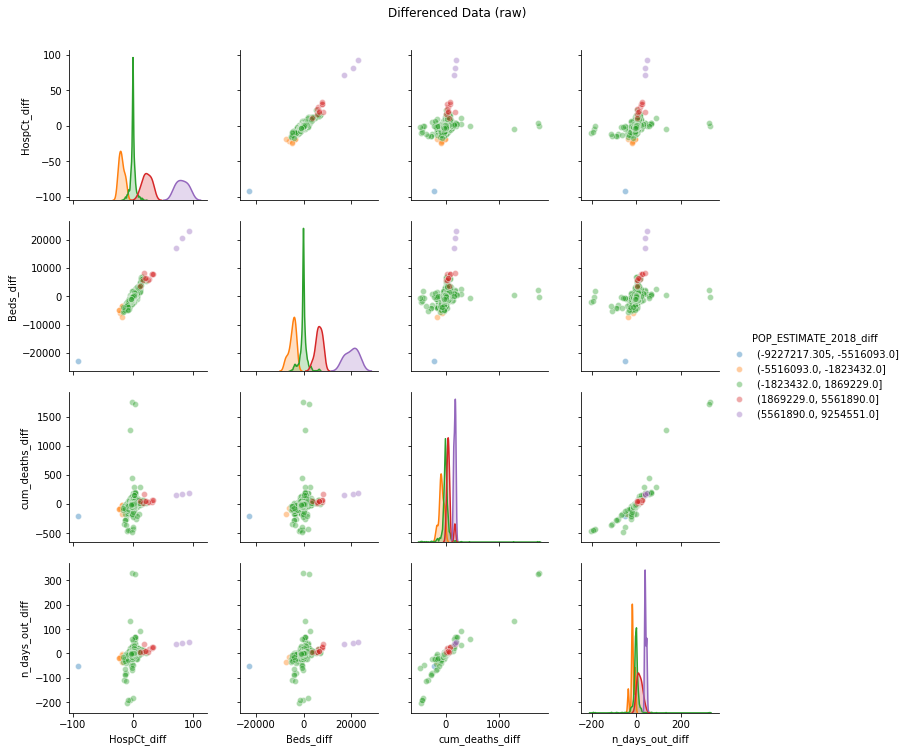

In [228]:
cols = ['HospCt',
        'Beds',
        'cum_deaths',
        'n_days_out',
        #'m50',
        #'inter_movement',
]
hue = 'POP_ESTIMATE_2018'

## cols to process, transform to apply
temp = get_paired_diffs(cols)
cols = [f'{c}_diff' for c in cols]; hue += '_diff'

temp[hue] = pd.cut(temp[hue], bins=5)

fig = sns.pairplot(temp, vars=cols, hue=hue, plot_kws={'alpha': 0.4})
fig.fig.suptitle('Differenced Data (raw)', y=1.04)
plt.show()

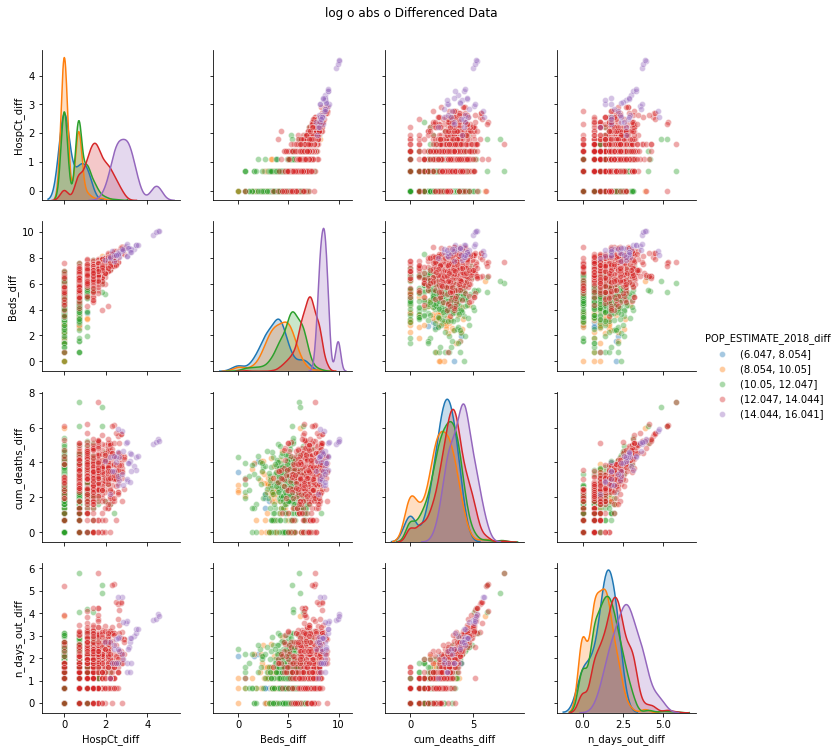

In [237]:
cols = ['HospCt',
        'Beds',
        'cum_deaths',
        'n_days_out',
        #'m50',
        #'inter_movement',
]
hue = 'POP_ESTIMATE_2018'

## cols to process, transform to apply
temp = get_paired_diffs(cols, diff_transform=lambda x: np.log(np.abs(x)+1))
cols = [f'{c}_diff' for c in cols]; hue += '_diff'

temp[hue] = pd.cut(temp[hue], bins=5)

fig = sns.pairplot(temp, vars=cols, hue=hue, plot_kws={'alpha': 0.4})
fig.fig.suptitle('log o abs o Differenced Data', y=1.04)
plt.show()

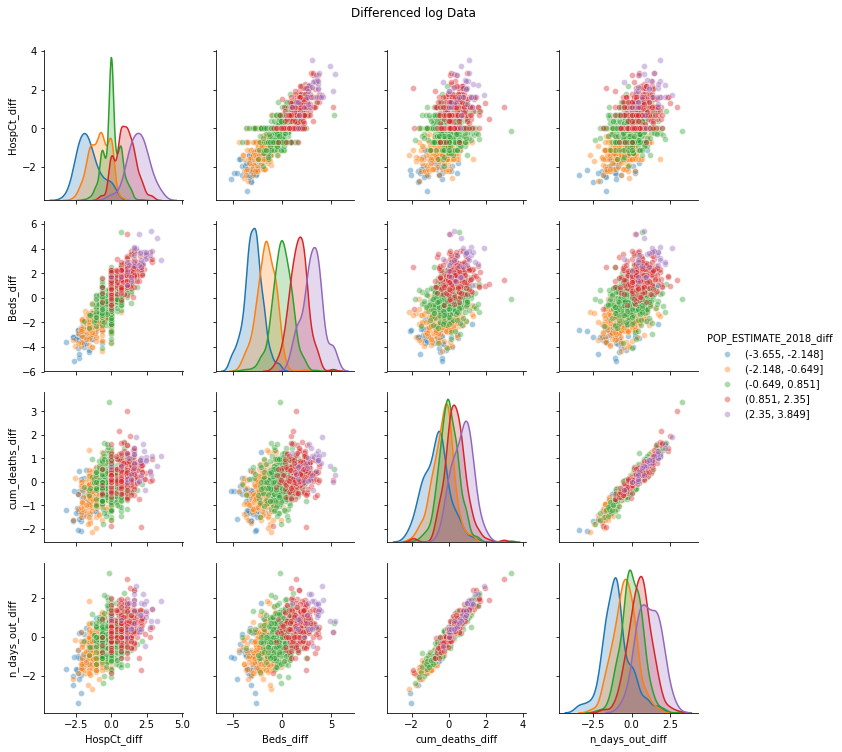

In [232]:
cols = ['HospCt',
        'Beds',
        'cum_deaths',
        'n_days_out',
        #'m50',
        #'inter_movement',
]
hue = 'POP_ESTIMATE_2018'

## cols to process, transform to apply
temp = get_paired_diffs(cols + [hue], row_transform=lambda x: np.log(x))
cols = [f'{c}_diff' for c in cols]; hue += '_diff'

temp[hue] = pd.cut(temp[hue], bins=5)

fig = sns.pairplot(temp, vars=cols, hue=hue, plot_kws={'alpha': 0.4})
fig.fig.suptitle('Differenced log Data', y=1.04)
plt.show()

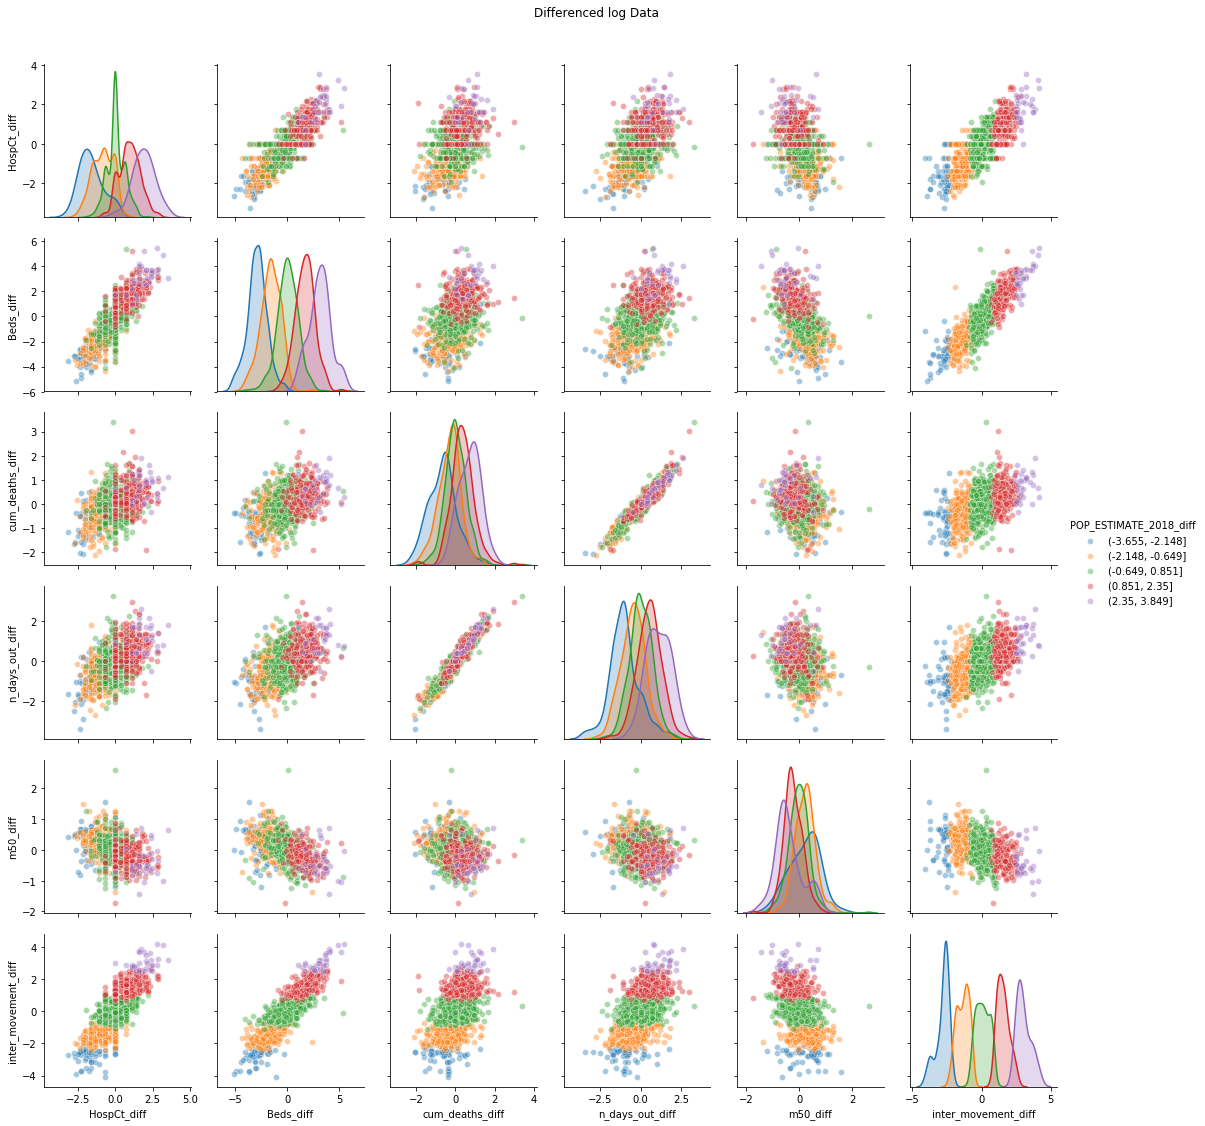

In [233]:
cols = ['HospCt',
        'Beds',
        'cum_deaths',
        'n_days_out',
        'm50',
        'inter_movement',
]
hue = 'POP_ESTIMATE_2018'

## cols to process, transform to apply
temp = get_paired_diffs(cols + [hue], row_transform=lambda x: np.log(x))
cols = [f'{c}_diff' for c in cols]; hue += '_diff'

temp[hue] = pd.cut(temp[hue], bins=5)

fig = sns.pairplot(temp, vars=cols, hue=hue, plot_kws={'alpha': 0.4})
fig.fig.suptitle('Differenced log Data', y=1.04)
plt.show()